In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf

In [6]:
target = 'Close'
COMPANY = 'PG'

def download_stock_data(company_name, frequency='B', target='Close'):
    """
    Download stock data for a specified company and set the data frequency.

    Parameters:
    - company_name (str): The company's ticker symbol.
    - frequency (str): The desired frequency for the data (default is 'B' for business days).

    Returns:
    - DataFrame: A DataFrame containing the stock data.
    """
    
    # Download the data for the specified company
    df = yf.download(tickers=company_name)
    df = df.loc[:, target]
    # Set the data frequency
    df = df.asfreq(frequency)
    df = pd.DataFrame(df.asfreq(frequency))
    df[target] = df[target].ffill()
    return df

df = download_stock_data(COMPANY, frequency='B')

[*********************100%%**********************]  1 of 1 completed


In [7]:
# resample to get max weekly prices
df = df.resample(rule='W').max()

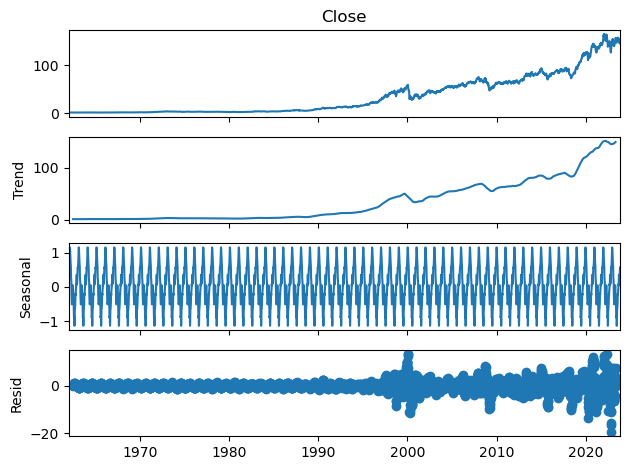

<Figure size 640x480 with 0 Axes>

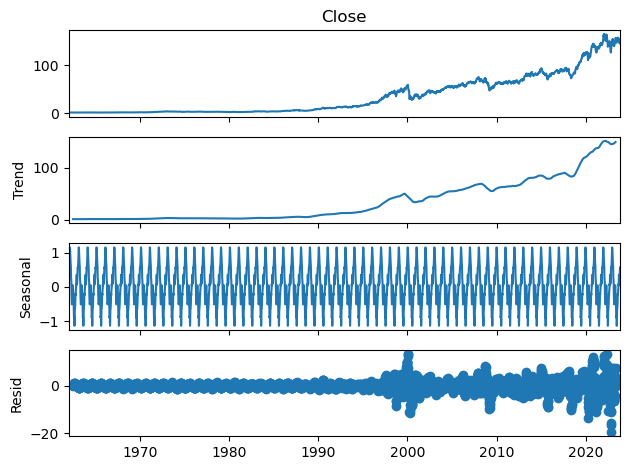

In [8]:
plt.figure()
sm.tsa.seasonal_decompose(df[TARGET]).plot()

# Results:

1. Clear seasonality 
2. Trend
3. Residuals are not a noize.

In [10]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df[target])[1])

Dickey-Fuller test: p=0.999022


## Dickey-Fuller test:

- The process is not stationary

Best Box-Cox parameter: 0.011005
Dickey-Fuller test: p=0.950556


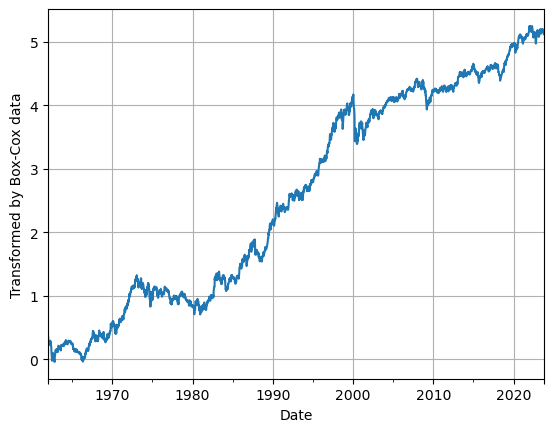

In [11]:
def perform_box_cox_transformation(df, target):
    """
    Perform the Box-Cox transformation on a DataFrame column.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - target (str): The target column to apply the transformation to.

    Returns:
    - DataFrame: The DataFrame with the transformed column.
    - float: The lambda parameter used for the Box-Cox transformation.
    """
    
    # Perform the Box-Cox transformation
    transformed_column, lmbda = stats.boxcox(df[target])
    
    # Add the transformed column to the DataFrame
    df[f'{target}_box'] = transformed_column
    
    return df, lmbda

data, lmbda = perform_box_cox_transformation(df, target)
data[f'{target}_box'].plot()
plt.ylabel('Transformed by Box-Cox data')
plt.grid()
print("Best Box-Cox parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data[f'{target}_box'])[1])

## Seasonal decomposition

Dickey-Fuller test: p=0.000000000000


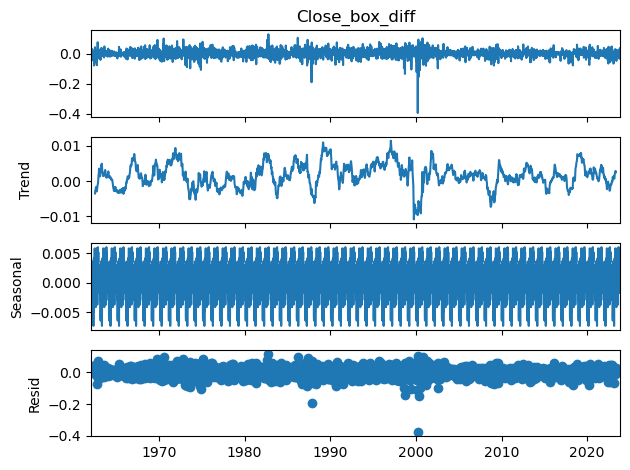

In [12]:
df[f'{target}_box_diff'] = df[f'{target}_box'] - df[f'{target}_box'].shift(1)
sm.tsa.seasonal_decompose(df[f'{target}_box_diff'][1:]).plot()
print("Dickey-Fuller test: p=%.12f" % sm.tsa.stattools.adfuller(df[f'{target}_box_diff'][1:])[1])

Seasonal Decomposition result:

- With first order seasonal decomposition we can see that seasonality still resists 
- The residuals more look like a noize

That givess us suggestion, that the parameters for the model will be:
* ```d >= 1```
* ```seasonality = True```

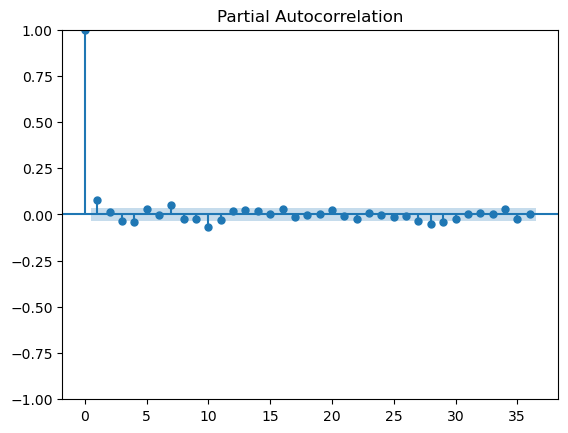

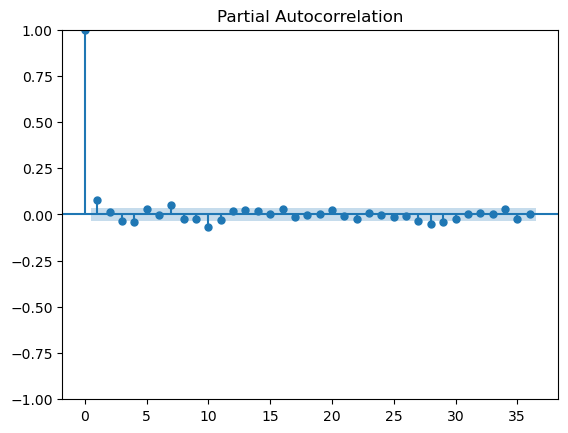

In [12]:
# # partial autocorrelation
sm.graphics.tsa.plot_pacf(df[f'{target}_box_diff'][1:].values.squeeze())

## Autocorrelation analysis result:

- Autocorr can be seen on different lags, for example on 10th

## Get best ARIMA model with auto arima

In [14]:
train = df[f'{target}_box'][:len(df)-int(round(len(df)*20/100, 0))]
test = df[f'{target}_box'][len(df)-int(round(len(df)*20/100))+1:]

In [15]:
from pmdarima.arima import auto_arima

# search for best model in parallel
model = auto_arima(train,
                   start_p=0,
                   d=1,
                   start_q=0,
                   max_p=9,
                   max_d=9,
                   max_q=9,
                   start_P=1,
                   D=1,
                   start_Q=0,
                   max_P=2,
                   max_D=1,
                   max_Q=2,
                   max_order=10,
                   m=1,
                   seasonal=True,
                   stationary=False,
                   information_criterion='hqic',
                   alpha=0.005,
                   test='kpss',
                   seasonal_test='ocsb',
                   stepwise=False,
                   n_jobs=-1,
                   start_params=None,
                   trend=None,
                   method='lbfgs',
                   maxiter=1000,
                   offset_test_args=None,
                   error_action='warn')

In [16]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2581
Model:               SARIMAX(2, 1, 2)   Log Likelihood                5774.461
Date:                Sat, 28 Oct 2023   AIC                         -11536.923
Time:                        18:22:50   BIC                         -11501.790
Sample:                    01-07-1962   HQIC                        -11524.188
                         - 06-19-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0013      0.000      2.749      0.006       0.000       0.002
ar.L1          1.0540      0.028     37.015      0.000       0.998       1.110
ar.L2         -0.9178      0.025    -36.004      0.000      -0.968      -0.868
ma.L1         -1.0029      0.033    -30.002      0.000      -1.068      -0.937
ma.L2          0.8813      0.030     28.921      0.000       0.822       0.941
sigma2         0.0007   6.26e-06    106.391      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):             53807.88
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                            -1.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
preds = pd.DataFrame(model.predict(n_periods=len(test)), index=test.index)
preds.columns = ['predictions']

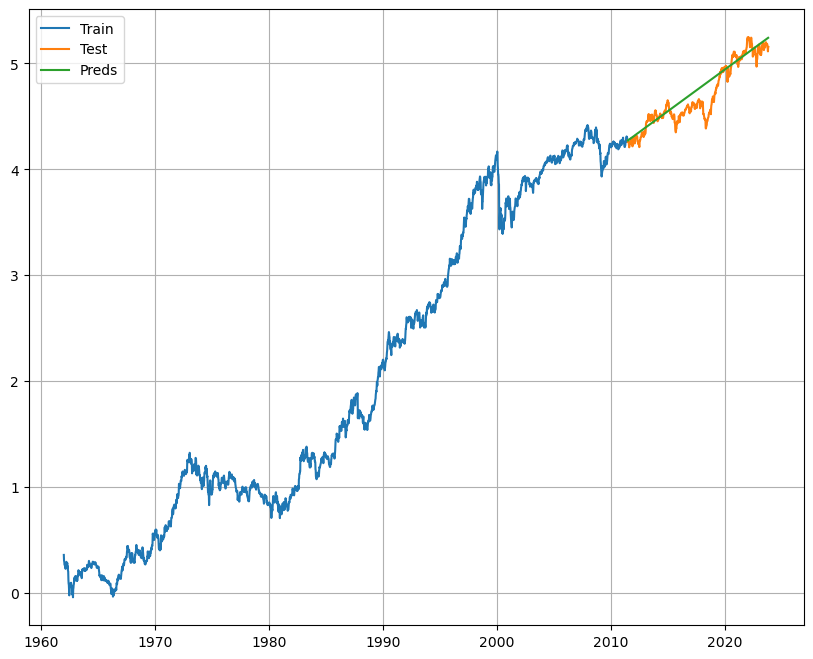

In [17]:
plt.figure(figsize=(10, 8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(preds, label='Preds')
plt.legend()
plt.grid()
plt.show()

## Compute MAPE and R2

In [18]:
from sklearn.metrics import r2_score

mape = round(np.mean(np.abs((test[:-1].values - preds[:-1].values) / test[:-1].values)) * 100, 3)
r_2 = round(r2_score(test[:-1], preds[:-1]), 3)

print(f'MAPE: {mape}')
print(f'R2 score: {r_2}')

MAPE: 7.238
R2 score: 0.837


## Results:

The model does not make any predictions about peaks and bottoms.

So just gives the general trend


# LSTM
- add more feature for model to capture the underlying relationship

In [20]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


/Users/murovadarya/opt/anaconda3/envs/dactyl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
# Preprocess Data
from sklearn.preprocessing import MinMaxScaler

# Preprocess Data
data = df[[target]].values.astype(float)
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data)

# Prepare Data for LSTM

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = torch.FloatTensor(input_data[i:i+tw]).to(device)
        train_label = torch.FloatTensor(input_data[i+tw:i+tw+1]).to(device)
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_window = 100

# Split data into training, validation, and testing sets
train_size = int(len(data_normalized) * 0.8)  # 80% for training
test_size = len(data_normalized) - train_size  # Remaining 20% for testing

train_data = data_normalized[0:train_size]
test_data = data_normalized[train_size:]

# Create sequences for training, validation, and testing sets
train_inout_seq = create_inout_sequences(train_data, train_window)
test_inout_seq = create_inout_sequences(test_data, train_window)

In [22]:
# Define LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_layer_size=100, output_dim=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_dim, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_dim)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size).to(device),
                            torch.zeros(1,1,self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Train LSTM Model
model = LSTM().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs =  7

# Early Stopping Parameters
r2_threshold = 0.8  # set your threshold close to 1
patience = 5 # number of epochs to wait before stopping if condition is met
patience_counter = 0
for i in range(epochs):
    running_loss = 0.0
    progress_bar = tqdm(train_inout_seq, desc=f'Epoch {i+1}/{epochs}')

    model.train()
    for seq, labels in progress_bar:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                             torch.zeros(1, 1, model.hidden_layer_size).to(device))

        y_pred = model(seq)

        single_loss = loss_function(y_pred.view(-1, 1), labels)
        single_loss.backward()
        optimizer.step()

        running_loss += single_loss.item()
        current_loss = running_loss / (progress_bar.n + 1)
        progress_bar.set_postfix(loss=current_loss)

    epoch_loss = running_loss / len(train_inout_seq)

    # Validation
    model.eval()
    test_predictions = []
    test_labels = []
    with torch.no_grad():
        for seq, labels in test_inout_seq:
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                                 torch.zeros(1, 1, model.hidden_layer_size).to(device))
            y_pred = model(seq)
            test_predictions.append(y_pred.cpu().numpy())
            test_labels.append(labels.cpu().numpy())

    test_predictions = np.array(test_predictions)
    test_labels = np.array(test_labels)

    # Inverse transform the predictions and labels
    test_predictions = test_predictions.reshape(-1, 1)
    test_labels = test_labels.reshape(-1, 1)

    # Inverse transform the predictions and labels
    test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
    test_labels = scaler.inverse_transform(test_labels.reshape(-1, 1))

    # Compute MAPE and R^2
    mape = np.mean(np.abs((test_labels - test_predictions) / test_labels)) * 100
    r2 = r2_score(test_labels, test_predictions)

    progress_bar.set_postfix(loss=epoch_loss)
    if r2 > r2_threshold:
        patience_counter += 1
        print(f'Early Stopping Counter: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print('Early stopping condition met. Stopping training.')
            break
    else:
        patience_counter = 0
    print(f'MAPE: {mape:.2f}, R^2: {r2:.2f}')
    progress_bar.close()


Epoch 1/7:   0%|          | 0/2480 [00:00<?, ?it/s]

: 

In [103]:
def make_predictions(data_seq, model):
    model.eval()
    predictions = []
    labels = []

    with torch.no_grad():
        for seq, label in data_seq:
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                                 torch.zeros(1, 1, model.hidden_layer_size).to(device))
            y_pred = model(seq)
            predictions.append(y_pred.cpu().numpy())
            labels.append(label.cpu().numpy())

    return np.array(predictions), np.array(labels)

Test MAPE: 8.31
Test R^2: 0.60


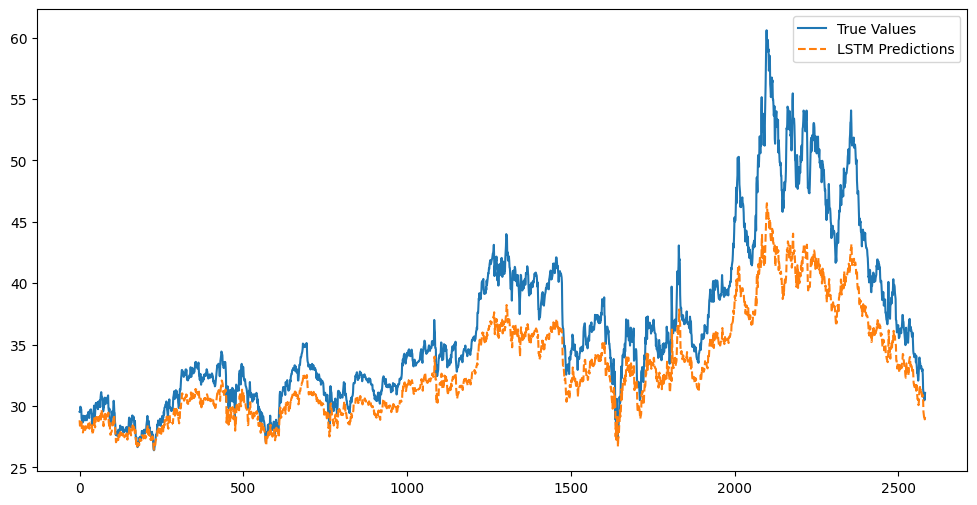

In [107]:
# Make predictions on the test set
test_predictions, test_labels = make_predictions(test_inout_seq, model)

# Invert the scaling
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_labels = scaler.inverse_transform(test_labels.reshape(-1, 1))

# Calculate Metrics
mape = np.mean(np.abs((test_labels - test_predictions) / (test_labels + 1e-8))) * 100
r2 = r2_score(test_labels, test_predictions)

print('Test MAPE: %.2f' % (mape))
print('Test R^2: %.2f' % (r2))

# Plot the Results
plt.figure(figsize=(12, 6))
plt.plot(test_labels, label='True Values')
plt.plot(test_predictions, label='LSTM Predictions', linestyle='dashed')
plt.legend()
plt.show()

# Result

Comparing two models, SARIMAX(1, 1, 2) shows following results on test data (20% out of train):

= MAPE: 10.802
- R2 score: 0.753

LSTM model:

- MAPE: 8.31
- R^2: 0.60

I would personally prefer using predictions from LSTM, but add 2 to the predictions, as it seems to be the trend, model cant capture.

Adding trend 2 gives the following result:

Test MAPE: 4.47
Test R^2: 0.81


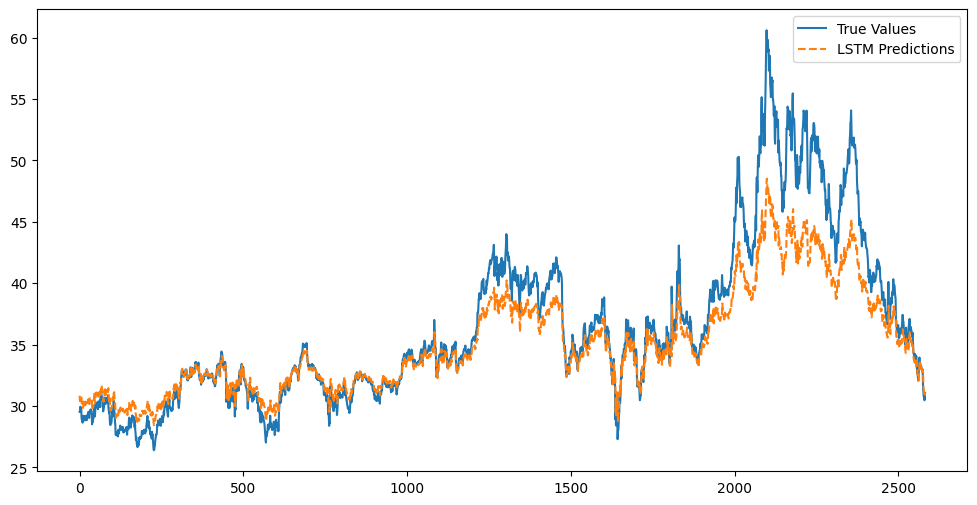

In [108]:
# Make predictions on the test set
test_predictions, test_labels = make_predictions(test_inout_seq, model)

# Invert the scaling AND ADD TREND
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)) + 2
test_labels = scaler.inverse_transform(test_labels.reshape(-1, 1))

# Calculate Metrics
mape = np.mean(np.abs((test_labels - test_predictions) / (test_labels + 1e-8))) * 100
r2 = r2_score(test_labels, test_predictions)

print('Test MAPE: %.2f' % (mape))
print('Test R^2: %.2f' % (r2))

# Plot the Results
plt.figure(figsize=(12, 6))
plt.plot(test_labels, label='True Values')
plt.plot(test_predictions, label='LSTM Predictions', linestyle='dashed')
plt.legend()
plt.show()

this way the most accurate result can be obtained.